<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. 

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
#!pip install scikit-learn==1.4 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor

RANDOM_STATE = 42

## Подготовка

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.shape

(26496, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
df.isna().sum()

num_orders    0
dtype: int64

**Вывод:** в датасете *df* 26496 записей и 1 признак. Столбец `datetime` уже преобразован в тип datetime64 и переведен в индекс, у столбца `num_orders` тип int64. Пропусков в данных нет.

## Анализ

Отсортируем индекс и ресемплируем наши данные по одному часу.

In [8]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df['rolling_mean'] = df.rolling(24).mean()

Построим график c заказами такси в аэропорт с марта по сентябрь 2018 года.

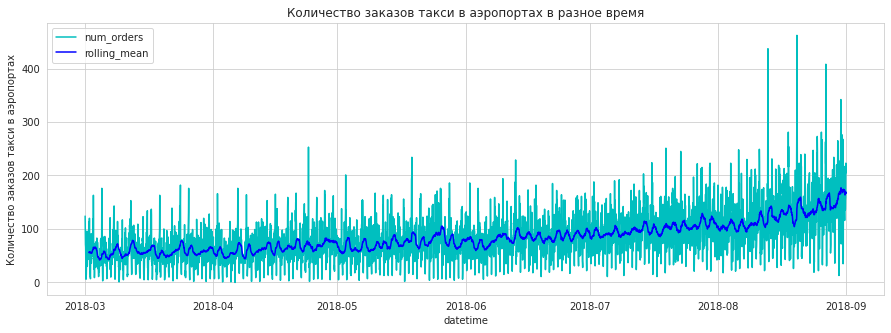

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
sns.lineplot(data=df[['num_orders', 'rolling_mean']], palette=['c', 'b'], dashes=False)
plt.title('Количество заказов такси в аэропортах в разное время')
plt.ylabel('Количество заказов такси в аэропортах')
plt.show()

Данные имеют большие колебания, но с помощью средней скользящей мы видим восхдящий тренд. Проведем детальный анализ временных рядов.

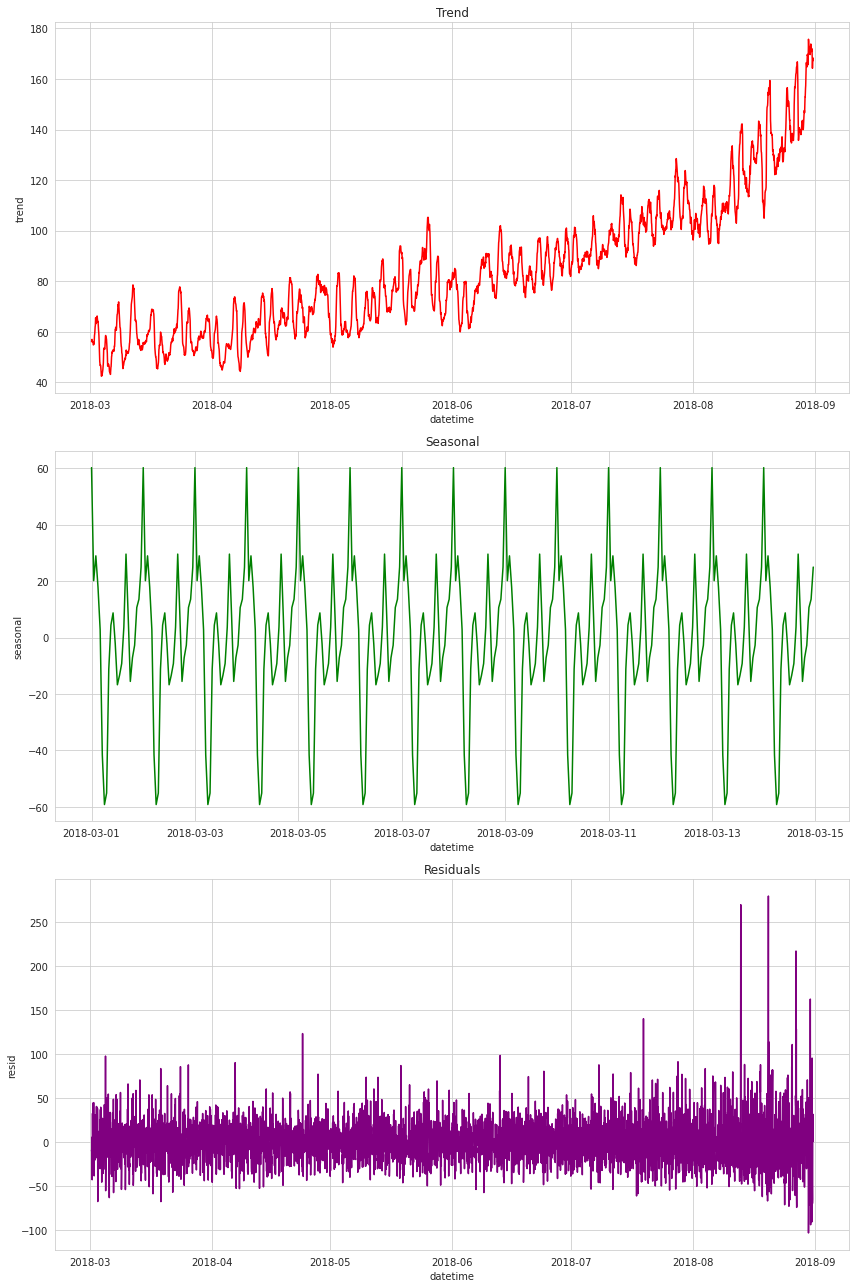

In [11]:
decomposed = seasonal_decompose(df['num_orders'])

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.lineplot(data=decomposed.trend, ax=axes[0], color='red')
axes[0].set_title('Trend')
sns.lineplot(data=decomposed.seasonal['01-03-2018':'14-03-2018'], ax=axes[1], color='green')
axes[1].set_title('Seasonal')
sns.lineplot(data=decomposed.resid, ax=axes[2], color='purple')
axes[2].set_title('Residuals')
plt.tight_layout();

Теперь хорошо видна суточная сезонность. Ночью количество заказов минимально, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

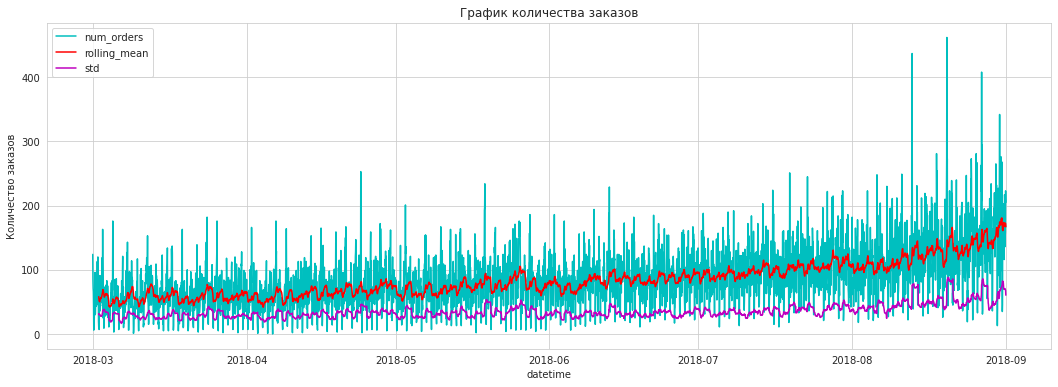

In [12]:
df_plot = df.copy()
plt.figure(figsize=(18, 6))
df_plot['rolling_mean'] = df_plot.rolling(30).mean()
df_plot['std'] = df_plot['num_orders'].rolling(30).std()
sns.lineplot(data=df_plot[['num_orders', 'rolling_mean', 'std']], palette=['c', 'r', 'm'], dashes=False)
plt.title('График количества заказов')
plt.ylabel('Количество заказов');

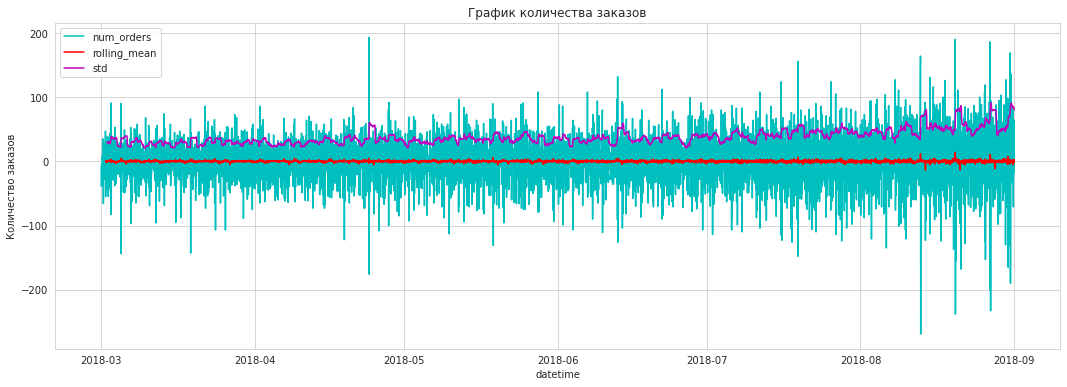

In [13]:
df_shift = df - df.shift()
plt.figure(figsize=(18, 6))
df_shift['mean'] = df_shift['num_orders'].rolling(30).mean()
df_shift['std'] = df_shift['num_orders'].rolling(30).std()
sns.lineplot(data=df_shift[['num_orders', 'rolling_mean', 'std']], palette=['c', 'r', 'm'], dashes=False)
plt.title('График количества заказов')
plt.ylabel('Количество заказов');

**Вывод:**
1. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа.
2. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.


## Обучение

Обучим три модели ориентируясь на метрику RMSE. В качестве моделей используем Линейную регрессию, Случайный лес и CatBoostRegressor.

Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data.dropna(inplace=True)

Применим функцию с лагом до 24 часов и 100-м скользящим средним.

In [15]:
make_features(df, 24, 24)

In [16]:
df.head()

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.833333,0,4,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,55.416667,1,4,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,56.875000,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,57.041667,3,4,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,56.958333,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


Поделим данные на тренировочную и тестовую выборки.

In [17]:
train, test = train_test_split(df, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 27)
(440, 27)
(3952,)
(440,)


**Линейная регрессия**

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [19]:
ohe_columns = ['hour',
              'dayofweek']

num_columns = df.drop(['hour',
              'dayofweek',
              'num_orders'], axis=1).columns

In [20]:
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [21]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [22]:
cv = TimeSeriesSplit(n_splits=3)

regression_cv_score = pd.Series(cross_val_score(
    pipe_final,
    features_train,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=cv)).mean()*(-1)

print(f'RMSE линейной регрессии при кросс-валидации: {regression_cv_score:.3f}')

RMSE линейной регрессии при кросс-валидации: 26.235


**Случайный лес**

In [23]:
%%time

params = {
    'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(10, 15),
    'models__min_samples_split': [2, 5, 10]
}

grid_forest = GridSearchCV(pipe_final, 
                    params, 
                    scoring='neg_root_mean_squared_error', 
                    cv=cv, 
                    n_jobs=-1)

grid_forest.fit(features_train, target_train)

CPU times: user 2min 29s, sys: 258 ms, total: 2min 29s
Wall time: 2min 30s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['hour',
                                                                          'dayofweek']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['rolling_mean', 'lag_1', 'lag_2', 'lag...
       'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13',
       'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20',
       'lag_21', 'lag_22', 'lag_23', 'lag_24'],
      dtype='object'))])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid={'models': [RandomForestRegressor(random_state=42)],
                         'models__max_depth': range(10, 15),
                         'models__min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [24]:
print(f'Лучшие параметры: {grid_forest.best_params_}')
print(f'RMSE случайного леса при кросс-валидации: {-grid_forest.best_score_:.3f}')

Лучшие параметры: {'models': RandomForestRegressor(random_state=42), 'models__max_depth': 14, 'models__min_samples_split': 5}
RMSE случайного леса при кросс-валидации: 27.236


**CatBoostRegressor**

In [25]:
%%time

cb_params = {
                'depth': [4, 6],
                'l2_leaf_reg': [1, 5],
                'min_data_in_leaf': [5, 10]
               }

grid_catboost = GridSearchCV(CatBoostRegressor(cat_features=['hour', 'dayofweek'], 
                                               iterations=2000, verbose=False, random_state=RANDOM_STATE), 
                    cb_params, 
                    scoring='neg_root_mean_squared_error', 
                    cv=cv, 
                    n_jobs=-1)
grid_catboost.fit(features_train, target_train)

CPU times: user 4min 6s, sys: 8.72 s, total: 4min 15s
Wall time: 5min 2s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f37c9624cd0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'l2_leaf_reg': [1, 5],
                         'min_data_in_leaf': [5, 10]},
             scoring='neg_root_mean_squared_error')

In [26]:
print(f'Лучшие параметры: {grid_catboost.best_params_}')
print(f'RMSE случайного леса при кросс-валидации: {-grid_catboost.best_score_:.3f}')

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 1, 'min_data_in_leaf': 5}
RMSE случайного леса при кросс-валидации: 25.568


**Вывод:**

Мы обучили 3 модели и подобрали гиперпараметры с помощью GridSearch. Для линеной регресии результат RMSE - 26.235, для случайного леса - 27.236, а для CatBoostRegressor - 25.568. Следовательно, для тестирования выберем модель CatBoostRegressor.

## Тестирование

**Проверка полученной модели на адекватность**

Для оценки на адекватность модели, попробуем дать предсказания сначала средним значением по всем тренировочным данным, а затем предсказанием значениями с предыдущих суток и с предыдущей недели.

In [27]:
constant_pred = np.ones(target_test.shape[0]) * target_train.mean()
print(f'RMSE при таргете-константе: {root_mean_squared_error(target_test, constant_pred):.3f}')

RMSE при таргете-константе: 84.688


In [28]:
day_shift = target_test.shift(24)
day_shift.iloc[:24] = target_train.iloc[-24:]
print(f'RMSE при предсказании значением этого же часа с предыдущих суток: \
{root_mean_squared_error(target_test, day_shift):.3f}')

RMSE при предсказании значением этого же часа с предыдущих суток: 57.303


In [29]:
week_shift = target_test.shift(168)
week_shift.iloc[:168] = target_train.iloc[-168:]
print(f'RMSE при предсказании значением этого же часа и этого же дня недели с предыдущей недели: \
{root_mean_squared_error(target_test, week_shift):.3f}')

RMSE при предсказании значением этого же часа и этого же дня недели с предыдущей недели: 39.542


Оценим выбранную модель на тестовых данных.

In [30]:
catboost_pred = grid_catboost.predict(features_test)
print(f'RMSE CatBoostRegressor на тестовых данных: {root_mean_squared_error(target_test, catboost_pred):.3f}')

RMSE CatBoostRegressor на тестовых данных: 39.509


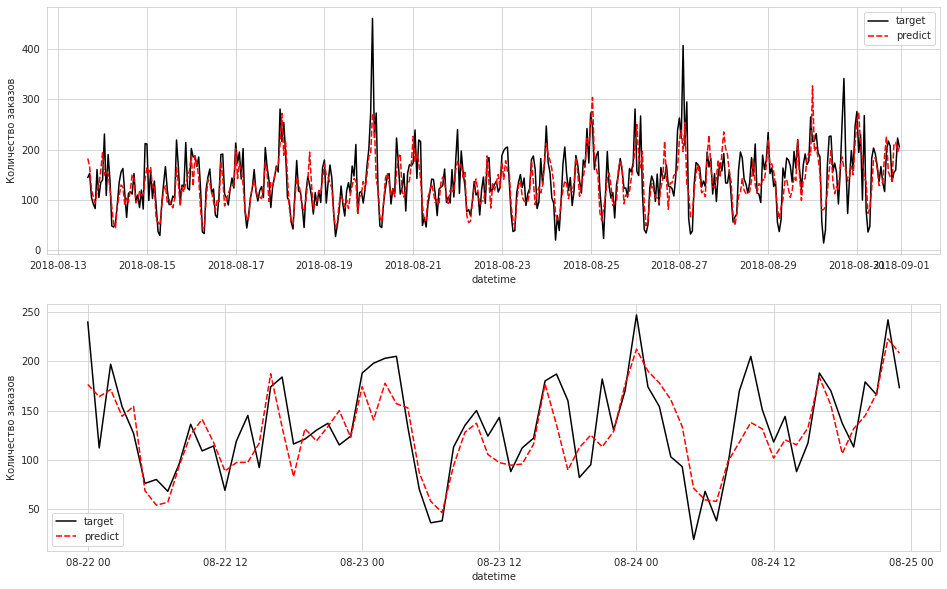

In [31]:
model_data = pd.DataFrame({"target":target_test, "predict":catboost_pred})
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
sns.lineplot(data=model_data[['target', 'predict']], ax=axes[0], palette=['k', 'r'])
axes[0].set_ylabel('Количество заказов')
sns.lineplot(data=model_data.loc['2018-08-22':'2018-08-24', ['target', 'predict']], ax=axes[1], palette=['k', 'r'])
axes[1].set_ylabel('Количество заказов')
plt.show()

**Вывод:**

Таким образом, наилучшая модель для прогноза количества заказов такси на следующий час, модель **CatBoostRegressor**, с параметром **depth = 4, l2_leaf_reg = 1, min_data_in_leaf = 5**, показывает результат RMSE на тестовых данных 39.509.

## Выводы

При выполнении проекта были получены следующие результаты:

1. На первом этапе произведена загрузка данных и их подготовка для обучения моделей.

2. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

3. На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час, "отстающие значения" и скользящее среднее. На дополненном датасете подобраны оптимальные гиперпараметры для моделей. Выбрана модель с наименьшей RMSE CatBoostRegressor.

4. На четвертом этапе проведено тестирование модели, а также проверка модели на адекватность. Показатель RMSE на тестовых данных у CatBoostRegressor = 39.509.